In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import LeaveOneOut
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import f_classif, SelectKBest, VarianceThreshold, RFECV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report

In [3]:
x = [] 
y = []
with open('../data/features.csv') as f:
    feature_name = f.readline()
    feature_name = feature_name.rstrip(os.linesep).split(',')
    feature_name = feature_name[1:]
    for line in f:
        x.append([])
        temp = line.rstrip(os.linesep).split(',')
        temp = temp[1:]
        for i in temp:
            if i == '':
                x[-1].append(np.nan)
            else:
                x[-1].append(float(i))
    f.close()
with open('../data/logBB.txt') as f:
    for line in f:
        temp = line.rstrip(os.linesep)
        y.append(float(temp))
    f.close()

In [4]:
x = np.array(x)
x = x.astype('float32')
y1 = [1 if i >= -1 else -1 for i in y ]
y2 = []
for i in y:
    if i >= 0.3:
        y2.append(0)
    elif i>= -1:
        y2.append(1)
    else:
        y2.append(2)

In [5]:
isnan = ~np.isnan(x).any(axis=0)
x = x[:,isnan]
feature_name = [feature_name[i] for i in range(len(isnan)) if isnan[i] ]
isinf = ~np.isinf(x).any(axis=0)
x = x[:,isinf]
feature_name = [feature_name[i] for i in range(len(isinf)) if isinf[i] ]
sel = VarianceThreshold()
x = sel.fit_transform(x)
feature_name = [feature_name[i] for i in range(len(sel.get_support())) if sel.get_support()[i]]
isneginf = ~np.isneginf(x).any(axis=0)
x = x[:,isneginf]
feature_name = [feature_name[i] for i in range(len(isneginf)) if isneginf[i] ]

In [6]:
clf = ExtraTreesClassifier(100000)
clf = clf.fit(x, y1)
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x.shape[1]):
    print("%d. %s (%f)" % (f + 1, feature_name[indices[f]], importances[indices[f]]))

Feature ranking:
1. MDEN-22 (0.008251)
2. nAcid (0.005958)
3. maxssssNp (0.005559)
4. minssssNp (0.005375)
5. nssssNp (0.005304)
6. ndsN (0.004869)
7. TopoPSA (0.004842)
8. maxdsN (0.004646)
9. mindsN (0.004630)
10. SssssNp (0.004490)
11. SdsN (0.004384)
12. nN (0.004244)
13. nHBAcc_Lipinski (0.003782)
14. MLFER_BH (0.003717)
15. maxHBd (0.003661)
16. WTPT-5 (0.003419)
17. nHBAcc (0.003392)
18. maxHsOH (0.003367)
19. MDEO-11 (0.003366)
20. MLFER_BO (0.003324)
21. SHBd (0.003324)
22. SHsOH (0.003247)
23. ATSC1c (0.003245)
24. minHBint2 (0.002908)
25. minHBint4 (0.002877)
26. naaO (0.002866)
27. maxHBint2 (0.002836)
28. MLFER_S (0.002700)
29. minHsOH (0.002671)
30. maxaaO (0.002653)
31. SaaO (0.002644)
32. minaaO (0.002624)
33. GGI4 (0.002600)
34. nHBDon_Lipinski (0.002574)
35. ATSC8c (0.002559)
36. WTPT-3 (0.002547)
37. maxHBint4 (0.002478)
38. minHBd (0.002464)
39. SHBint4 (0.002463)
40. nHBDon (0.002433)
41. nHBd (0.002429)
42. TPC (0.002406)
43. MPC8 (0.002364)
44. R_TpiPCTPC (0.0023

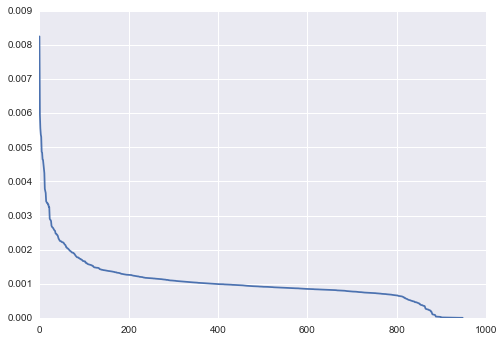

In [7]:
plt.plot(importances[indices])

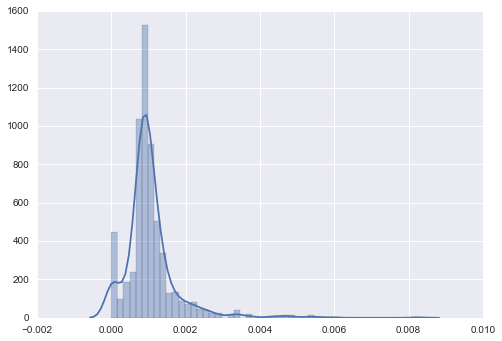

In [8]:
sns.distplot(importances[indices])

In [9]:
threshold = np.mean(importances[indices])+2*np.std(importances[indices])
for i in range(len(importances)):
    if importances[indices[i]]<threshold:
        cutoff_feature_index = i
        break
print(cutoff_feature_index)

36


In [10]:
feature_start = feature_name.index('WTPT-1')
feature_end = feature_name.index('WTPT-5')
x_WTPT = x[:,feature_start:(feature_end+1)]
lda = LinearDiscriminantAnalysis(priors=[0.9,0.1])
lda.fit(x_WTPT,y1)
y_pred = lda.predict(x_WTPT)
print(classification_report(y1, y_pred))

lr = LogisticRegression()
lr.fit(x_WTPT,y1)
y_pred = lr.predict(x_WTPT)
print(classification_report(y1, y_pred))

# svc = SVC(kernel='linear')
# svc.fit(x_WTPT,y1)
# y_pred = svc.predict(x_WTPT)
# print(classification_report(y1, y_pred))

rfecv = RFECV(estimator=lda, step=1, cv=StratifiedKFold(y1, 20), scoring='roc_auc')
rfecv.fit(x_WTPT, y1)
model = rfecv.estimator_
x_WTPT_selected = x_WTPT[:,rfecv.support_]
y_pred = model.predict(x_WTPT_selected)
print("Optimal number of features : %d" % rfecv.n_features_)
print(classification_report(y1, y_pred))

rfecv = RFECV(estimator=lr, step=1, cv=StratifiedKFold(y1, 20), scoring='roc_auc')
rfecv.fit(x_WTPT, y1)
model = rfecv.estimator_
x_WTPT_selected = x_WTPT[:,rfecv.support_]
y_pred = model.predict(x_WTPT_selected)
print("Optimal number of features : %d" % rfecv.n_features_)
print(classification_report(y1, y_pred))

# rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(y1, 20), scoring='roc_auc')
# rfecv.fit(x_WTPT, y1)
# model = rfecv.estimator_
# x_WTPT_selected = x_WTPT[:,rfecv.support_]
# y_pred = model.predict(x_WTPT_selected)
# print("Optimal number of features : %d" % rfecv.n_features_)
# print(classification_report(y1, y_pred))


             precision    recall  f1-score   support

         -1       0.14      1.00      0.24        75
          1       1.00      0.06      0.10       506

avg / total       0.89      0.18      0.12       581

             precision    recall  f1-score   support

         -1       0.58      0.15      0.23        75
          1       0.89      0.98      0.93       506

avg / total       0.85      0.88      0.84       581

Optimal number of features : 3
             precision    recall  f1-score   support

         -1       0.13      1.00      0.24        75
          1       1.00      0.04      0.07       506

avg / total       0.89      0.16      0.09       581

Optimal number of features : 5
             precision    recall  f1-score   support

         -1       0.58      0.15      0.23        75
          1       0.89      0.98      0.93       506

avg / total       0.85      0.88      0.84       581



In [11]:
feature_start = feature_name.index('MLFER_A')
feature_end = feature_name.index('MLFER_L')
x_MLFER = x[:,feature_start:(feature_end+1)]
lda = LinearDiscriminantAnalysis()
lda.fit(x_MLFER,y1)
y_pred = lda.predict(x_MLFER)
print(classification_report(y1, y_pred))

lr = LogisticRegression()
lr.fit(x_MLFER,y1)
y_pred = lr.predict(x_MLFER)
print(classification_report(y1, y_pred))

svc = SVC(kernel='linear')
svc.fit(x_MLFER,y1)
y_pred = svc.predict(x_MLFER)
print(classification_report(y1, y_pred))

rfecv = RFECV(estimator=lda, step=1, cv=StratifiedKFold(y1, 20), scoring='roc_auc')
rfecv.fit(x_MLFER, y1)
model = rfecv.estimator_
x_MLFER_selected = x_MLFER[:,rfecv.support_]
y_pred = model.predict(x_MLFER_selected)
print("Optimal number of features : %d" % rfecv.n_features_)

print(classification_report(y1, y_pred))

rfecv = RFECV(estimator=lr, step=1, cv=StratifiedKFold(y1, 20), scoring='roc_auc')
rfecv.fit(x_MLFER, y1)
model = rfecv.estimator_
x_MLFER_selected = x_MLFER[:,rfecv.support_]
y_pred = model.predict(x_MLFER_selected)
print("Optimal number of features : %d" % rfecv.n_features_)
print(classification_report(y1, y_pred))

rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(y1, 20), scoring='roc_auc')
rfecv.fit(x_MLFER, y1)
model = rfecv.estimator_
x_MLFER_selected = x_MLFER[:,rfecv.support_]
y_pred = model.predict(x_MLFER_selected)
print("Optimal number of features : %d" % rfecv.n_features_)
print(classification_report(y1, y_pred))


             precision    recall  f1-score   support

         -1       0.66      0.28      0.39        75
          1       0.90      0.98      0.94       506

avg / total       0.87      0.89      0.87       581

             precision    recall  f1-score   support

         -1       0.79      0.15      0.25        75
          1       0.89      0.99      0.94       506

avg / total       0.87      0.88      0.85       581

             precision    recall  f1-score   support

         -1       0.00      0.00      0.00        75
          1       0.87      1.00      0.93       506

avg / total       0.76      0.87      0.81       581



/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Optimal number of features : 5
             precision    recall  f1-score   support

         -1       0.66      0.28      0.39        75
          1       0.90      0.98      0.94       506

avg / total       0.87      0.89      0.87       581

Optimal number of features : 4
             precision    recall  f1-score   support

         -1       0.71      0.16      0.26        75
          1       0.89      0.99      0.94       506

avg / total       0.86      0.88      0.85       581

Optimal number of features : 5
             precision    recall  f1-score   support

         -1       0.00      0.00      0.00        75
          1       0.87      1.00      0.93       506

avg / total       0.76      0.87      0.81       581



/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [12]:
x_selected = x[:,indices[0:cutoff_feature_index]]
# feature_name = [feature_name[i] for i in indices[0:cutoff_feature_index]]
# svc = SVC(kernel="linear")
lda = LinearDiscriminantAnalysis()
# lr =
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=lda, step=1, cv=StratifiedKFold(y1, 20), scoring='recall_micro')
rfecv.fit(x_selected, y1)
print("Optimal number of features : %d" % rfecv.n_features_)
x_selected_selected = x_selected[:,rfecv.support_]
# feature_name = [feature_name[i] for i in range(len(rfecv.support_)) if rfecv.support_[i]]
model = rfecv.estimator_
y_pred = model.predict(x_selected_selected)
print(classification_report(y1, y_pred))

rfecv = RFECV(estimator=lr, step=1, cv=StratifiedKFold(y1, 20), scoring='recall_micro')
rfecv.fit(x_selected, y1)
print("Optimal number of features : %d" % rfecv.n_features_)
x_selected_selected = x_selected[:,rfecv.support_]
# feature_name = [feature_name[i] for i in range(len(rfecv.support_)) if rfecv.support_[i]]
model = rfecv.estimator_
y_pred = model.predict(x_selected_selected)
print(classification_report(y1, y_pred))

rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(y1, 20), scoring='recall_micro')
rfecv.fit(x_selected, y1)
print("Optimal number of features : %d" % rfecv.n_features_)
x_selected_selected = x_selected[:,rfecv.support_]
# feature_name = [feature_name[i] for i in range(len(rfecv.support_)) if rfecv.support_[i]]
model = rfecv.estimator_
y_pred = model.predict(x_selected_selected)
print(classification_report(y1, y_pred))


/usr/local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.5/site-packages/sklearn

Optimal number of features : 4
             precision    recall  f1-score   support

         -1       0.79      0.20      0.32        75
          1       0.89      0.99      0.94       506

avg / total       0.88      0.89      0.86       581

Optimal number of features : 8
             precision    recall  f1-score   support

         -1       0.74      0.33      0.46        75
          1       0.91      0.98      0.94       506

avg / total       0.89      0.90      0.88       581

Optimal number of features : 36
             precision    recall  f1-score   support

         -1       0.83      0.33      0.48        75
          1       0.91      0.99      0.95       506

avg / total       0.90      0.91      0.89       581

